In [ ]:
# Installation helper: installs transfermarkt-wrapper into the current notebook interpreter if tmkt is missing
import sys
import subprocess
try:
    # This uses the same Python executable the kernel is running 
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'transfermarkt-wrapper'])
    print('transfermarkt-wrapper installed (or already present)')
except Exception as e:
    print('Installation failed:', e)

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import requests
from tmkt import TMKT
import json
import asyncio
from mplsoccer.pitch import Pitch

In [ ]:
### Validar esta parte do código
player_id = 433177
url = f"https://transfermarkt-api.fly.dev/players/{player_id}/profile"
resp = requests.get(url)
data = resp.json()
print(data)
market_value = data.get('market_value')
print("Valor de mercado:", market_value)


In [146]:
#Leitura do dataset simplificado -> com 165 colunas
df = pd.read_csv(f'data/players_data_light-2024_2025.csv',index_col='Rk', parse_dates=True)
#df.columns.to_list()

In [147]:
# Seleção de colunas relevantes
selected_columns = [
    'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Min', '90s', 'Starts',
    'Cmp', 'Att', 'Cmp%', 'PrgP', '1/3', 'Tkl', 'TklW', 'Att 3rd', 'Int','PPA','KP',
    'PrgC', 'Att 3rd_stats_possession', 'Gls', 'Ast', 'xG', 'xAG'
]

# Criar DataFrame com colunas selecionadas
df_selected = df[selected_columns]
df_selected

,Player,Nation,Pos,Squad,Comp,Age,Min,90s,Starts,Cmp,Att,Cmp%,PrgP,1/3,Tkl,TklW,Att 3rd,Int,PPA,KP,PrgC,Att 3rd_stats_possession,Gls,Ast,xG,xAG
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Max Aarons,eng ENG,DF,Bournemouth,eng Premier League,24.0,86,1.0,1,50,63,79.4,8,8,2,2,0,1,0,0,1,15,0,0,0.0,0.0
2,Max Aarons,eng ENG,"DF,MF",Valencia,es La Liga,24.0,120,1.3,1,47,66,71.2,6,2,4,4,0,0,0,1,0,36,0,0,0.0,0.0
3,Rodrigo Abajas,es ESP,DF,Valencia,es La Liga,21.0,65,0.7,1,17,29,58.6,2,0,3,2,0,1,0,0,3,9,0,0,0.1,0.0
4,James Abankwah,ie IRL,"DF,MF",Udinese,it Serie A,20.0,88,1.0,0,36,46,78.3,4,2,4,2,0,1,0,0,3,7,0,0,0.1,0.0
5,Keyliane Abdallah,fr FRA,FW,Marseille,fr Ligue 1,18.0,3,0.0,0,2,2,100.0,0,0,1,1,0,0,0,0,1,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850,Edhy Zuliani,fr FRA,DF,Toulouse,fr Ligue 1,19.0,9,0.1,0,2,2,100.0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0
2851,Szymon Żurkowski,pl POL,MF,Empoli,it Serie A,26.0,106,1.2,0,27,33,81.8,1,0,6,4,0,1,1,0,1,7,0,0,0.1,0.0
2852,Martin Ødegaard,no NOR,MF,Arsenal,eng Premier League,25.0,2325,25.8,26,1237,1499,82.5,258,132,19,11,3,6,86,63,92,875,3,8,4.8,5.4


In [148]:
# Substituir NaN por 0 nas métricas de desempenho (quando jogador atuou)
df_selected.loc[df_selected['Min']> 0] = df_selected.loc[df_selected['Min'] > 0 ].fillna(0)
df_selected

,Player,Nation,Pos,Squad,Comp,Age,Min,90s,Starts,Cmp,Att,Cmp%,PrgP,1/3,Tkl,TklW,Att 3rd,Int,PPA,KP,PrgC,Att 3rd_stats_possession,Gls,Ast,xG,xAG
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Max Aarons,eng ENG,DF,Bournemouth,eng Premier League,24.0,86,1.0,1,50,63,79.4,8,8,2,2,0,1,0,0,1,15,0,0,0.0,0.0
2,Max Aarons,eng ENG,"DF,MF",Valencia,es La Liga,24.0,120,1.3,1,47,66,71.2,6,2,4,4,0,0,0,1,0,36,0,0,0.0,0.0
3,Rodrigo Abajas,es ESP,DF,Valencia,es La Liga,21.0,65,0.7,1,17,29,58.6,2,0,3,2,0,1,0,0,3,9,0,0,0.1,0.0
4,James Abankwah,ie IRL,"DF,MF",Udinese,it Serie A,20.0,88,1.0,0,36,46,78.3,4,2,4,2,0,1,0,0,3,7,0,0,0.1,0.0
5,Keyliane Abdallah,fr FRA,FW,Marseille,fr Ligue 1,18.0,3,0.0,0,2,2,100.0,0,0,1,1,0,0,0,0,1,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850,Edhy Zuliani,fr FRA,DF,Toulouse,fr Ligue 1,19.0,9,0.1,0,2,2,100.0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0
2851,Szymon Żurkowski,pl POL,MF,Empoli,it Serie A,26.0,106,1.2,0,27,33,81.8,1,0,6,4,0,1,1,0,1,7,0,0,0.1,0.0
2852,Martin Ødegaard,no NOR,MF,Arsenal,eng Premier League,25.0,2325,25.8,26,1237,1499,82.5,258,132,19,11,3,6,86,63,92,875,3,8,4.8,5.4


In [149]:
#Identificar as posições existentes
df_selected['Pos'].unique()

array(['DF', 'DF,MF', 'FW', 'MF,FW', 'MF', 'FW,MF', 'GK', 'FW,DF',
       'DF,FW', 'MF,DF'], dtype=object)

In [150]:
#Informações básicas para seleção de atletas entre 20 e 26 anos com minutagem acima de 900 minutos e não seja goleiro
df_filtred = df_selected[
    (df_selected['Age'].between(20,26)) &
    (df_selected['Min']>= 900) &
    (df_selected['Pos']!= 'GK')
]
df_filtred

,Player,Nation,Pos,Squad,Comp,Age,Min,90s,Starts,Cmp,Att,Cmp%,PrgP,1/3,Tkl,TklW,Att 3rd,Int,PPA,KP,PrgC,Att 3rd_stats_possession,Gls,Ast,xG,xAG
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,
7,Himad Abdelli,dz ALG,"MF,FW",Angers,fr Ligue 1,24.0,2842,31.6,32,1373,1672,82.1,207,171,48,32,15,26,38,39,107,597,6,1,6.4,3.2
11,Abel,es ESP,DF,Osasuna,es La Liga,23.0,2074,23.0,20,776,1071,72.5,77,57,61,37,8,18,18,16,50,357,2,0,0.5,1.0
14,Matthis Abline,fr FRA,FW,Nantes,fr Ligue 1,21.0,2768,30.8,33,351,538,65.2,48,23,11,5,5,4,15,27,75,438,9,2,8.5,3.8
15,Abner,br BRA,DF,Lyon,fr Ligue 1,24.0,1090,12.1,12,568,675,84.1,66,45,29,20,7,5,11,11,31,225,1,1,0.6,1.1
16,Zakaria Aboukhlal,ma MAR,"MF,FW",Toulouse,fr Ligue 1,24.0,1901,21.1,22,221,349,63.3,22,16,22,13,7,6,10,12,34,363,7,2,10.2,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,Edon Zhegrova,xk KVX,"FW,MF",Lille,fr Ligue 1,25.0,978,10.9,12,316,416,76.0,54,17,5,2,2,4,26,16,37,346,4,1,2.3,2.2
2842,Joshua Zirkzee,nl NED,"FW,MF",Manchester Utd,eng Premier League,23.0,1402,15.6,14,292,410,71.2,44,26,14,8,3,6,6,12,14,219,3,1,4.8,1.5
2845,Nadir Zortea,it ITA,"DF,MF",Cagliari,it Serie A,25.0,2713,30.1,33,557,827,67.4,63,42,30,14,2,19,31,28,69,387,6,2,3.1,2.4


In [ ]:
df_filtred.info()

In [151]:
#Filtro para selecionar zagueiros e volantes
df_filtred_df_mf = df_filtred[df_filtred['Pos'].str.contains('^(DF|MF)(,|$)|\b(DF|MF)\b', na=False)]
df_filtred_df_mf

# Calcular estatísticas descritivas
tkl_stats = df_filtred_df_mf['Tkl'].describe()
tklw_stats = df_filtred_df_mf['TklW'].describe()
prgp = df_filtred_df_mf['PrgP'].describe()

# Estatísticas defensivas mínimas para um zagueiro e um volante
df_stats_df_mf = df_filtred_df_mf[
    (df_filtred_df_mf['PrgP'] > 20) & #Passes progressivos
    (df_filtred_df_mf['Cmp%'] >= 75) & # Precisão de passes
    (df_filtred_df_mf['Tkl'] >= 20) & # Total de Interceptações
    (df_filtred_df_mf['TklW'] >= 15)  #  Interceptações vencidas
    ] 
df_stats_df_mf

# Criar pontuação composta
df_stats_df_mf['Score'] = (
    df_stats_df_mf['PrgP'] +  # Progressão
    (df_stats_df_mf['Cmp%'] - 75) * 0.4 +  # Bônus por precisão acima de 75%
    df_stats_df_mf['TklW'] * 0.6  # Peso para tackles vencidos
)
df_stats_df_mf = df_stats_df_mf.sort_values(by='Score', ascending=False)
df_stats_df_mf

/tmp/ipykernel_1883/404942967.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_df_mf['Score'] = (


,Player,Nation,Pos,Squad,Comp,Age,Min,90s,Starts,Cmp,Att,Cmp%,PrgP,1/3,Tkl,TklW,Att 3rd,Int,PPA,KP,PrgC,Att 3rd_stats_possession,Gls,Ast,xG,xAG,Score
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,,
2061,Pedri,es ESP,MF,Barcelona,es La Liga,21.0,2879,32.0,35,2404,2749,87.4,360,331,61,34,9,26,79,70,92,988,4,5,2.2,7.4,385.36
1081,Mattéo Guendouzi,fr FRA,MF,Lazio,it Serie A,25.0,3270,36.3,37,1961,2183,89.8,316,287,37,21,5,32,33,43,89,538,1,3,1.4,3.2,334.52
1508,Manuel Locatelli,it ITA,MF,Juventus,it Serie A,26.0,2822,31.4,34,2134,2431,87.8,294,327,72,49,8,23,31,29,33,408,2,2,1.8,2.5,328.52
2507,Angelo Stiller,de GER,MF,Stuttgart,de Bundesliga,23.0,2741,30.5,31,2219,2540,87.4,289,271,49,27,6,26,50,59,39,556,1,8,1.8,7.2,310.16
1091,Bruno Guimarães,br BRA,MF,Newcastle Utd,eng Premier League,26.0,3271,36.3,38,1481,1798,82.4,271,180,83,47,12,29,77,52,64,662,5,6,4.3,6.1,302.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,Raúl Asencio,es ESP,DF,Real Madrid,es La Liga,21.0,1670,18.6,18,927,988,93.8,27,47,22,16,0,16,3,6,5,37,0,1,0.1,0.6,44.12
2260,Max Rosenfelder,de GER,DF,Freiburg,de Bundesliga,21.0,1249,13.9,13,576,675,85.3,29,23,27,17,0,7,4,5,24,74,1,0,0.4,0.7,43.32
2372,Joël Schingtienne,be BEL,DF,Venezia,it Serie A,21.0,1122,12.5,12,420,487,86.2,28,16,27,16,2,14,2,3,5,60,0,0,0.0,0.1,42.08


SELEÇÃO DE ZAGUEIROS

In [152]:
# Selecionar os 5 melhores zagueiros:
df_top_df = df_stats_df_mf[df_stats_df_mf['Pos'].str.contains('DF')].nlargest(5, 'Score')
df_top_df
#f_top_df.to_csv('top_5_df.csv', index=False)

,Player,Nation,Pos,Squad,Comp,Age,Min,90s,Starts,Cmp,Att,Cmp%,PrgP,1/3,Tkl,TklW,Att 3rd,Int,PPA,KP,PrgC,Att 3rd_stats_possession,Gls,Ast,xG,xAG,Score
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,,
1107,Joško Gvardiol,hr CRO,DF,Manchester City,eng Premier League,22.0,3277,36.4,36,2454,2721,90.2,264,247,58,39,12,44,20,26,91,815,5,0,4.6,2.1,293.48
435,Moisés Caicedo,ec ECU,"MF,DF",Chelsea,eng Premier League,22.0,3351,37.2,38,1967,2194,89.7,215,235,114,73,16,49,34,30,43,476,1,2,0.8,3.0,264.68
1137,Jan Paul van Hecke,nl NED,DF,Brighton,eng Premier League,24.0,2958,32.9,33,2016,2286,88.2,228,226,45,29,2,24,17,15,55,166,1,1,1.3,1.5,250.68
2667,Federico Valverde,uy URU,"MF,DF",Real Madrid,es La Liga,26.0,3032,33.7,34,2010,2237,89.9,226,232,50,30,5,55,31,39,66,572,6,4,2.7,3.1,249.96
1755,Óscar Mingueza,es ESP,"MF,DF",Celta Vigo,es La Liga,25.0,2729,30.3,31,1692,2197,77.0,200,176,38,24,5,22,69,35,69,759,4,6,1.5,5.6,215.20


In [153]:
#Tabela com os colunas de interesse
df_top_df = df_top_df[['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Min', 'Cmp', 'Cmp%', 'PrgP', 'Tkl', 'TklW', 'Int', 'PrgC', 'Score']]
df_top_df

,Player,Nation,Pos,Squad,Comp,Age,Min,Cmp,Cmp%,PrgP,Tkl,TklW,Int,PrgC,Score
Rk,,,,,,,,,,,,,,,
1107,Joško Gvardiol,hr CRO,DF,Manchester City,eng Premier League,22.0,3277,2454,90.2,264,58,39,44,91,293.48
435,Moisés Caicedo,ec ECU,"MF,DF",Chelsea,eng Premier League,22.0,3351,1967,89.7,215,114,73,49,43,264.68
1137,Jan Paul van Hecke,nl NED,DF,Brighton,eng Premier League,24.0,2958,2016,88.2,228,45,29,24,55,250.68
2667,Federico Valverde,uy URU,"MF,DF",Real Madrid,es La Liga,26.0,3032,2010,89.9,226,50,30,55,66,249.96
1755,Óscar Mingueza,es ESP,"MF,DF",Celta Vigo,es La Liga,25.0,2729,1692,77.0,200,38,24,22,69,215.20


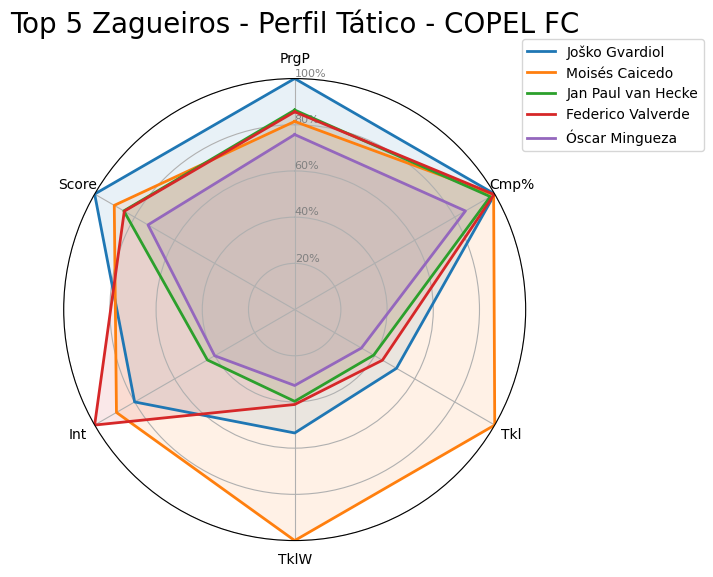

In [154]:
# Função para criar gráfico de radar
def plot_radar_chart(data, title):
    categories = ['PrgP', 'Cmp%', 'Tkl','TklW', 'Int', 'Score']
    N = len(categories)

    # Normalizar os dados (0 a 1)
    max_values = data[categories].max()
    normalized_data = data[categories].div(max_values)

    # Configurar o gráfico
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Fechar o círculo

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"], color="grey", size=8)
    plt.ylim(0, 1)

    # Plotar para cada jogador
    for i, row in normalized_data.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=data.loc[i, 'Player'])
        ax.fill(angles, values, alpha=0.1)

    plt.title(title, size=20, color='black', y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
    plt.show()

# Gerar gráfico
plot_radar_chart(df_top_df, 'Top 5 Zagueiros - Perfil Tático - COPEL FC')

#### Valor de mercado dos jogadores

In [ ]:
async with TMKT() as tmkt:
        # Buscar jogador por nome
        players = await tmkt.player_search("Moisés Caicedo")
        print(players)  # Mostra lista de possíveis matches
        # Pegar detalhes de jogador (inclui valor de mercado)
        player_id = players[0]['id']  # Pegue o ID correto do seu atleta
        player = await tmkt.get_player(player_id)
        print(json.dumps(player, indent=4))
        # player['market_value'] trará o valor de mercado
        pd.json_normalize(player,sep='_')


In [160]:
df = await tmkt.player_search("Moisés Caicedo")
df

[{'id': '687626', 'name': 'Moisés Caicedo Chelsea FC', 'club': 'Chelsea FC'}]

In [161]:
# Supondo que a coluna seja 'id' ou 'data_id' ou algo similar
df_player_id = df[0]['id']
df_player_id

'687626'

In [162]:
df_player = await tmkt.get_player(df_player_id)
df_player = pd.json_normalize(df_player)
df_player

,success,message,data.id,data.name,data.shortName,data.artistName,data.displayName,data.lifeDates.age,data.lifeDates.dateOfBirth,data.lifeDates.isDateOfBirthUnknown,data.lifeDates.dateOfDeath,data.lifeDates.isDateOfDeathUnknown,data.birthPlaceDetails.placeOfBirth,data.birthPlaceDetails.countryOfBirthId,data.birthPlaceDetails.placeOfBirthAdditionalInfo,data.birthPlaceDetails.gender,data.nationalityDetails.passportName,data.nationalityDetails.nationalities.nationalityId,data.nationalityDetails.nationalities.secondNationalityId,data.attributes.height,data.attributes.preferredFootId,data.attributes.outfitterId,data.attributes.positionGroup,data.attributes.positionGroupName,data.attributes.positionId,data.attributes.firstSidePositionId,data.attributes.secondSidePositionId,data.attributes.lastContractRenewal.year,data.attributes.lastContractRenewal.month,data.attributes.lastContractRenewal.day,data.attributes.contractUntil,data.attributes.formerClubsNote,data.attributes.consultantAgencyId,data.attributes.preferredFoot.id,data.attributes.preferredFoot.name,data.attributes.position.id,data.attributes.position.name,data.attributes.position.shortName,data.attributes.position.category,data.attributes.firstSidePosition.id,data.attributes.firstSidePosition.name,data.attributes.firstSidePosition.shortName,data.attributes.firstSidePosition.category,data.attributes.secondSidePosition.id,data.attributes.secondSidePosition.name,data.attributes.secondSidePosition.shortName,data.attributes.secondSidePosition.category,data.attributes.consultantAgency.id,data.attributes.consultantAgency.name,data.attributes.consultantAgency.shortName,data.attributes.consultantAgency.verificationStatus,data.attributes.consultantAgency.verificationDate,data.attributes.consultantAgency.unlockedDomains,data.attributes.consultantAgency.isSpecialConsultantAgency,data.attributes.consultantAgency.hasGlobalPremiumAccess,data.attributes.consultantAgency.relativeUrl,data.preferences.themeId,data.relativeUrl,data.portraitUrl,data.portraitUrlSource,data.marketValueDetails.current.value,data.marketValueDetails.current.currency,data.marketValueDetails.current.compact.prefix,data.marketValueDetails.current.compact.content,data.marketValueDetails.current.compact.suffix,data.marketValueDetails.current.determined,data.marketValueDetails.previous.value,data.marketValueDetails.previous.currency,data.marketValueDetails.previous.compact.prefix,data.marketValueDetails.previous.compact.content,data.marketValueDetails.previous.compact.suffix,data.marketValueDetails.previous.determined,data.marketValueDetails.delta.value,data.marketValueDetails.delta.percentage,data.marketValueDetails.delta.isVisible,data.marketValueDetails.delta.type,data.marketValueDetails.highest.value,data.marketValueDetails.highest.currency,data.marketValueDetails.highest.compact.prefix,data.marketValueDetails.highest.compact.content,data.marketValueDetails.highest.compact.suffix,data.marketValueDetails.highest.determined,data.clubAssignments
0,True,OK,687626,Moisés Caicedo,M. Caicedo,,,24,2001-11-02,False,None,False,Santo Domingo,44,,male,Moisés Isaac Caicedo Corozo,44,0,1.78,2,0,MIDFIELDER,Midfielder,6,7,5,None,None,None,2031-06-30T00:00:00+02:00,"CD Espoli (-5/2016), Colorados SC (5/2016-8/20...",13796,2,right,6,Defensive Midfield,DM,Midfielder,7,Central Midfield,CM,Midfielder,5,Right-Back,RB,Defender,13796,AS1,AS1,verified,2024-12-04,[],False,True,/as1/beraterfirma/berater/13796,0,/moises-caicedo/profil/spieler/687626,https://img.a.transfermarkt.technology/portrai...,imago images,100000000,EUR,€,100.00,M,2025-10-17,90000000,EUR,€,90.00,M,2025-05-30,+10.000.000 €,"+11,11 %",False,INCREASED,100000000,EUR,€,100.00,M,2025-10-17,"[{'playerId': '687626', 'clubId': '631', 'shir..."


In [159]:
df_club = pd.json_normalize(main_data['clubAssignments'])
df_club


,playerId,clubId,shirtNumber,isCaptain,type,debut,start
0,687626,631,25.0,False,current,2023-08-20,2023-08-14
1,687626,5750,NaN,False,nationalTeam,2020-10-09,NaN


In [ ]:
df_columns = df_player[['data_shortName', 'data_lifeDates_age', 'data_lifeDates_dateOfBirth','data_attributes_height', 'data_marketValueDetails_delta_percentage', 'data_marketValueDetails_highest_value', 'data_marketValueDetails_highest_currency', 'data_marketValueDetails_highest_compact_content', 'data_attributes_positionGroupName', 'data_attributes_preferredFoot_name', 'data_marketValueDetails_current_value', 'Tkl', 'TklW', 'Int', 'PrgC', 'Score']]


SELEÇÃO DE VOLANTES

In [ ]:
# Selecionar os 5 melhores volantes:
df_top_mf = df_stats_df_mf[df_stats_df_mf['Pos'].str.contains('MF')].nlargest(5, 'Score')
df_top_mf
#df_top_mf.to_csv('top_5_mf.csv', index=False)   

In [ ]:
df_top_mf.columns.to_list()

In [ ]:
#Tabela com os colunas de interesse
df_top_mf = df_top_mf[['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Min', 'Cmp', 'Cmp%', 'PrgP', 'Tkl', 'TklW', 'Int', 'PrgC','1/3', 'Score']]
df_top_df

In [ ]:
# Função para criar gráfico de radar
def plot_radar_chart(data, title):
    categories = ['PrgP', 'Cmp%', 'TklW', 'Int', 'Score', '1/3']
    N = len(categories)

    # Normalizar os dados (0 a 1)
    max_values = data[categories].max()
    normalized_data = data[categories].div(max_values)

    # Configurar o gráfico
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Fechar o círculo

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"], color="grey", size=8)
    plt.ylim(0, 1)

    # Plotar para cada jogador
    for i, row in normalized_data.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=data.loc[i, 'Player'])
        ax.fill(angles, values, alpha=0.1)

    plt.title(title, size=20, color='black', y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
    plt.show()

# Gerar gráfico
plot_radar_chart(df_top_mf, 'Top 5 Volantes - Perfil Tático - COPEL FC')

SELEÇÃO DE ATACANTES

In [ ]:
#Filtro para selecionar atacantes
df_filtred_fw = df_filtred[df_filtred['Pos'].str.contains('^(FW|MF)(,|$)|\b(FW|MF)\b', na=False)]
df_filtred_fw

# Calcular estatísticas descritivas
kp_stats = df_filtred_fw['KP'].describe()
ppa_stats = df_filtred_fw['PPA'].describe()
xg_stats = df_filtred_fw['xG'].describe()
prgp_stats = df_filtred_fw['PrgP'].describe()


# Estatísticas defensivas mínimas para um zagueiro e um volante
df_stats_fw = df_filtred_fw[
    (df_filtred_fw['PrgP']>40) & #Passes progressivos
    (df_filtred_fw['xG'] >= 1.5) & # Expectativa de gols
    (df_filtred_fw['KP'] >= 15) & # Passes chave
    (df_filtred_fw['PPA'] >= 10)&   #  Passes para ações de perigo
    (df_filtred_fw['TklW'] >= 15) &
    (df_filtred_fw['Int'] >= 10)
    ] 
df_stats_fw


# Criar pontuação composta
df_stats_fw['Score'] = (
    df_stats_fw['xG'] * 1.3 +  
    df_stats_fw['PPA'] * 1.5 +  # Peso para passes para ações de perigo
    df_stats_fw['KP'] * 1.5 +  # Peso para passes chave
    df_stats_fw['TklW'] * 1.0 +  # Peso para tackles vencidos
    df_stats_fw['Int'] * 1.2  # Peso para interceptações    
)
df_stats_fw = df_stats_fw.sort_values(by='Score', ascending=False)
df_top_fw = df_stats_fw.nlargest(5, 'Score')
df_top_fw

In [ ]:
#Visualização das métricas descritivas para os zagueiros e volantes
print('métricas Tkl:\n'+ f'{tkl_stats}\n')
print('métricas Tklw:\n'+ f'{tklw_stats}\n')    
print('métricas PrgP:\n'+ f'{prgp}')

In [ ]:
# Função para criar gráfico de radar
def plot_radar_chart(data, title):
    categories = ['xG', 'PPA', 'KP', 'TklW', 'Int', 'Score']
    N = len(categories)

    # Normalizar os dados (0 a 1)
    max_values = data[categories].max()
    normalized_data = data[categories].div(max_values)

    # Configurar o gráfico
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Fechar o círculo

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"], color="grey", size=8)
    plt.ylim(0, 1)

    # Plotar para cada jogador
    for i, row in normalized_data.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=data.loc[i, 'Player'])
        ax.fill(angles, values, alpha=0.1)

    plt.title(title, size=20, color='black', y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
    plt.show()

# Gerar gráfico
plot_radar_chart(df_top_fw, 'Top 4 atacantes - Perfil Tático - COPEL FC')

In [ ]:
#Visualização das métricas descritivas para atacantes
print('métricas KP:\n'+ f'{kp_stats}\n')
print('métricas PPA:\n'+ f'{ppa_stats}\n')    
print('métricas xG:\n'+ f'{xg_stats}\n')
print('métricas PrgP:\n'+ f'{prgp_stats}\n')    

In [ ]:
#df_top_fw.to_csv('top_5_fw.csv', index=False)